<a href="https://colab.research.google.com/github/streakcraze/PRODIGY_ML_03/blob/main/image_classification_using_svm_(with_edge_detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Acquisition

In [1]:
import shutil

shutil.unpack_archive("/content/drive/MyDrive/Colab Notebooks/image-classification-using-svm/dogs-vs-cats/train.zip")

In [2]:
import os

train_images_list = sorted(os.listdir("train"))

print(f"the train dataset has {len(train_images_list)} images")

the train dataset has 25000 images


In [3]:
print(train_images_list[0])
print(train_images_list[-1])

cat.0.jpg
dog.9999.jpg


In [4]:
import re

cat_images = [x for x in train_images_list if re.match("cat", x)]
dog_images = [x for x in train_images_list if re.match("dog", x)]

print(f"{len(cat_images)} cat images")
print(f"{len(dog_images)} dog images")

12500 cat images
12500 dog images


# 2. Data Preprocessing

In [5]:
import numpy as np
from skimage import io, color, filters, transform
import matplotlib.pyplot as plt
import gc

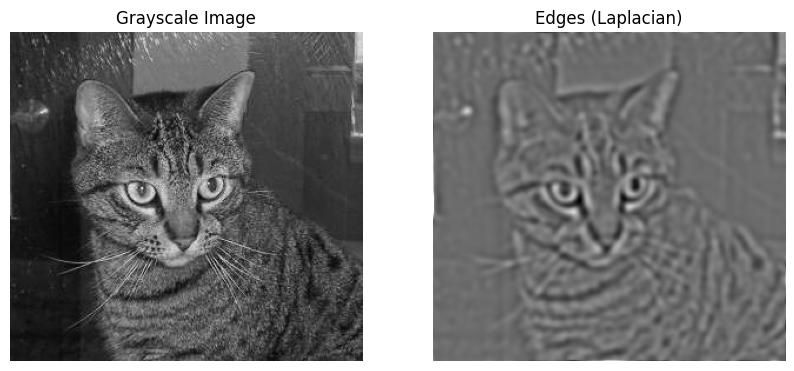

In [6]:
cat_img = io.imread(os.path.join("train", cat_images[1]))
cat_gray = color.rgb2gray(cat_img)

# applying Laplacian of Gaussian (LoG) filter for edge detection
cat_filter = filters.gaussian(cat_gray, sigma=3)
cat_edges = filters.laplace(cat_filter)

# plotting the original and edges images side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cat_edges, cmap='gray')
plt.title('Edges (Laplacian)')
plt.axis('off')

plt.show()

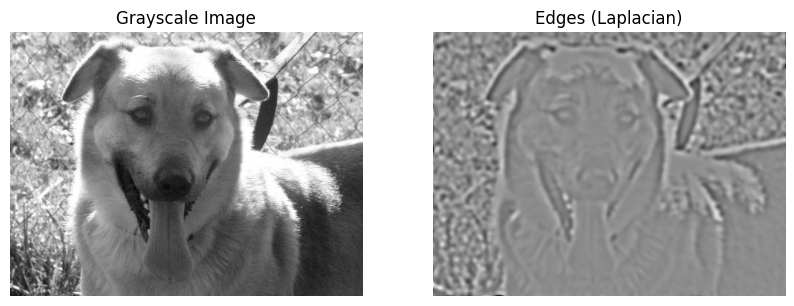

In [7]:
dog_img = io.imread(os.path.join("train", dog_images[10000]))
dog_gray = color.rgb2gray(dog_img)

# applying Laplacian of Gaussian (LoG) filter for edge detection
dog_filter = filters.gaussian(dog_gray, sigma=3)
dog_edges = filters.laplace(dog_filter)

# plotting the original and edges images side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(dog_gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dog_edges, cmap='gray')
plt.title('Edges (Laplacian)')
plt.axis('off')

plt.show()

In [8]:
features = np.array([])
# "0" for cat and "1" for dog
labels = np.append(np.full(12500, 0), np.full(12500, 1))

In [9]:
cat_features = []

print("loading cat images ...")

for img in cat_images:
  # load the RGB image
  rgb_img = io.imread(os.path.join("train", img))
  # convert RGB to grayscale
  gray_img = color.rgb2gray(rgb_img)
  # applying Gaussian smoothing
  filter_img = filters.gaussian(gray_img, sigma=3)
  # applying Laplace operator for edge detection
  edge_img = filters.laplace(filter_img)
  # resize the image
  resized_img = transform.resize(edge_img, (50, 50))
  # normalize the image
  normalized_img = resized_img / 255.0
  # flatten the image array
  flat_img = normalized_img.flatten()
  # append to features list
  cat_features.append(flat_img)

features = np.vstack(cat_features)
del cat_features
gc.collect()
print("loaded cat images successfully")

loading cat images ...
loaded cat images successfully


In [10]:
dog_features = []

print("loading dog images ...")

for img in dog_images:
  # load the RGB image
  rgb_img = io.imread(os.path.join("train", img))
  # convert RGB to grayscale
  gray_img = color.rgb2gray(rgb_img)
  # applying Gaussian smoothing
  filter_img = filters.gaussian(gray_img, sigma=3)
  # applying Laplace operator for edge detection
  edge_img = filters.laplace(filter_img)
  # resize the image
  resized_img = transform.resize(edge_img, (50, 50))
  # normalize the image
  normalized_img = resized_img / 255.0
  # flatten the image array
  flat_img = normalized_img.flatten()
  # append to features list
  dog_features.append(flat_img)

features = np.append(features, dog_features, axis=0)
del dog_features
gc.collect()
print("loaded dog images successfully")

loading dog images ...
loaded dog images successfully


In [11]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
import joblib

In [12]:
print("applying principal component analysis ...")

# Calculate the covariance matrix
cov_matrix = np.cov(features, rowvar=False)
# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
# Sort eigenvalues and corresponding eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
# Calculate explained variance ratio
total_variance = np.sum(eigenvalues)
explained_variance_ratio = eigenvalues/total_variance
# Choose the number of principal components based on explained variance threshold
variance_threshold = 0.95  # Adjust based on your desired explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
num_components = np.argmax(cumulative_explained_variance >= variance_threshold) + 1
# Apply PCA with the chosen number of principal components
pca = PCA(n_components=num_components)
principal_features = pca.fit_transform(features)

# principal_features now contains the reduced-dimensional data using PCA
print(f"features reduced from {len(features[0])} to {len(principal_features[0])}")

del features
gc.collect()
print("principal component analysis completed")

applying principal component analysis ...
features reduced from 2500 to 1646
principal component analysis completed


# 3. Model Training

In [13]:
print("splitting data into training and test sets")
x_train, x_test, y_train, y_test = train_test_split(principal_features, labels, test_size=0.3, random_state=77, stratify=labels)
del principal_features
del labels
gc.collect()
print("split completed")

splitting data into training and test sets
split completed


In [14]:
# Defining the parameters grid for GridSearchCV
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, "scale"]}

# Creating a support vector classifier
svc = svm.SVC(kernel="rbf", probability=True)

# Creating a model using GridSearchCV with the parameters grid
model = GridSearchCV(svc, param_grid, cv=2, verbose=3)

In [15]:
# training the model
print("model training started ...")
model.fit(x_train, y_train)
print("model training completed")

# cleaning up
joblib.dump(model, "/content/drive/MyDrive/Colab Notebooks/image-classification-using-svm/image_classifier_svm(5).sav")
del x_train
del y_train
gc.collect()
print("model artifact saved")

model training started ...
Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END .................C=0.1, gamma=0.01;, score=0.500 total time=11.8min
[CV 2/2] END .................C=0.1, gamma=0.01;, score=0.500 total time=11.9min
[CV 1/2] END ..................C=0.1, gamma=0.1;, score=0.500 total time=12.0min
[CV 2/2] END ..................C=0.1, gamma=0.1;, score=0.500 total time=12.1min
[CV 1/2] END ................C=0.1, gamma=scale;, score=0.539 total time=12.1min
[CV 2/2] END ................C=0.1, gamma=scale;, score=0.529 total time=11.7min
[CV 1/2] END ...................C=1, gamma=0.01;, score=0.500 total time=11.7min
[CV 2/2] END ...................C=1, gamma=0.01;, score=0.500 total time=12.0min
[CV 1/2] END ....................C=1, gamma=0.1;, score=0.500 total time=11.9min
[CV 2/2] END ....................C=1, gamma=0.1;, score=0.500 total time=12.0min
[CV 1/2] END ..................C=1, gamma=scale;, score=0.547 total time=11.8min
[CV 2/2] END .........

# 4. Model Evaluation

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [17]:
# testing the model
y_pred = model.predict(x_test)

# calculating the accuracy of the model
accuracy = accuracy_score(y_pred, y_test)
print(f"The model is {accuracy*100}% accurate")

The model is 57.90666666666666% accurate


In [18]:
# printing the classification report
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=['cat', 'dog']))

Classification report:
              precision    recall  f1-score   support

         cat       0.58      0.57      0.57      3750
         dog       0.58      0.59      0.58      3750

    accuracy                           0.58      7500
   macro avg       0.58      0.58      0.58      7500
weighted avg       0.58      0.58      0.58      7500



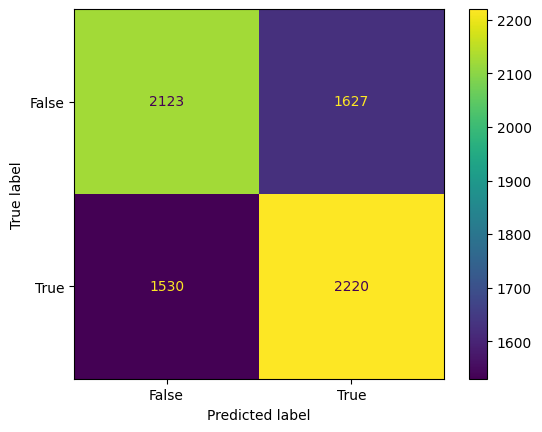

In [19]:
# plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
cm_display.plot()
plt.show()

In [20]:
shutil.unpack_archive("/content/drive/MyDrive/Colab Notebooks/image-classification-using-svm/dogs-vs-cats/test1.zip")

In [21]:
test_images_list = sorted(os.listdir("test1"))

print(f"the test dataset has {len(test_images_list)} images")

the test dataset has 12500 images


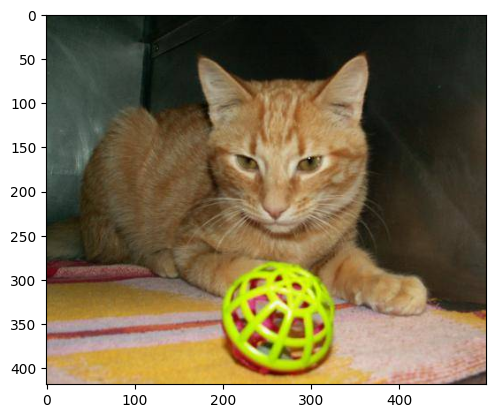

cat = 42.94247280144411%
dog = 57.0575271985559%
The predicted image is dog


In [24]:
test_img = io.imread(os.path.join("test1", test_images_list[100]))

plt.imshow(test_img)
plt.show()

test_img_features = []

gray_test_img = color.rgb2gray(test_img)
filter_test_img = filters.gaussian(gray_test_img, sigma=3)
edge_test_img = filters.laplace(filter_test_img)
resized_test_img = transform.resize(edge_test_img, (50, 50))
normalized_test_img = resized_test_img / 255.0
flat_test_img = normalized_test_img.flatten()
test_img_features.append(flat_test_img)

for i in range(num_components):
  test_img_features.append(np.full(len(flat_test_img), 1))

principal_test_components = pca.fit_transform(np.vstack(test_img_features))
principal_test_img = [principal_test_components[0]]

probability = model.predict_proba(principal_test_img)[0]

print(f'cat = {probability[0]*100}%')
print(f'dog = {probability[1]*100}%')

if model.predict(principal_test_img)[0] == 0:
  print("The predicted image is cat")
else:
  print("The predicted image is dog")

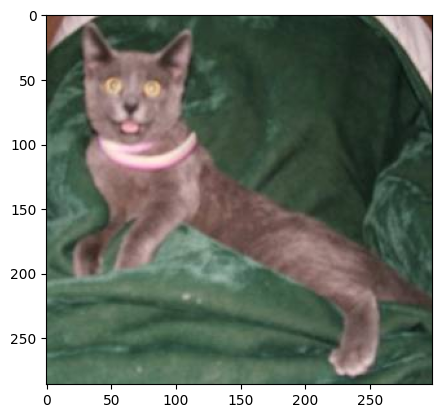

cat = 42.94247280144411%
dog = 57.0575271985559%
The predicted image is dog


In [25]:
test_img = io.imread(os.path.join("test1", test_images_list[200]))

plt.imshow(test_img)
plt.show()

test_img_features = []

gray_test_img = color.rgb2gray(test_img)
filter_test_img = filters.gaussian(gray_test_img, sigma=3)
edge_test_img = filters.laplace(filter_test_img)
resized_test_img = transform.resize(edge_test_img, (50, 50))
normalized_test_img = resized_test_img / 255.0
flat_test_img = normalized_test_img.flatten()
test_img_features.append(flat_test_img)

for i in range(num_components):
  test_img_features.append(np.full(len(flat_test_img), 1))

principal_test_components = pca.fit_transform(np.vstack(test_img_features))
principal_test_img = [principal_test_components[0]]

probability = model.predict_proba(principal_test_img)[0]

print(f'cat = {probability[0]*100}%')
print(f'dog = {probability[1]*100}%')

if model.predict(principal_test_img)[0] == 0:
  print("The predicted image is cat")
else:
  print("The predicted image is dog")